<a href="https://colab.research.google.com/github/muhammadalifalfarizi/Dataset-Satelit-ML/blob/main/Final_Submission_Dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUHAMMAD ALIF ALFARIZI** 

# **1494037162101-564**

Import all library

In [1]:
import zipfile, os
import pandas as pd
import numpy as np
import tensorflow as tf 

Load dataset dari Kaggle

In [2]:
! chmod 600 /content/kaggle.json 

In [3]:
! KAGGLE_CONFIG_DIR=/content/ kaggle  datasets download -d mahmoudreda55/satellite-image-classification

 92% 20.0M/21.8M [00:00<00:00, 207MB/s]
100% 21.8M/21.8M [00:00<00:00, 207MB/s]


Extrat zip ke tmp

In [6]:
local_zip= '/content/satellite-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [11]:
base_dir = '/tmp/data'

In [12]:
os.listdir(base_dir)

['water', 'cloudy', 'desert', 'green_area']

Preprocessing data dan dibagi menjadi 80% train set 20% test set 

In [19]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2)

In [27]:
train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='categorical',
        subset='validation')

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


Model Sequential dan Conv2D Maxpooling Layer

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Penggunaan Callback pada model

In [49]:
class TestCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')> 0.88 and logs.get('val_accuracy') > 0.88):
      print("\nAkurasi telah mencapai 88%!")
      self.model.stop_training=True
callbacks = TestCallback()

In [50]:
hist = model.fit(
      train_generator, 
      steps_per_epoch=30, 
      epochs=30,
      validation_data=validation_generator, 
      verbose=2,
      callbacks=[callbacks])

Epoch 1/30
30/30 - 11s - loss: 0.2693 - accuracy: 0.8927 - val_loss: 0.3274 - val_accuracy: 0.8712 - 11s/epoch - 370ms/step
Epoch 2/30
30/30 - 11s - loss: 0.3950 - accuracy: 0.8115 - val_loss: 0.2642 - val_accuracy: 0.8934 - 11s/epoch - 366ms/step
Epoch 3/30

Akurasi telah mencapai 88%!
30/30 - 12s - loss: 0.2578 - accuracy: 0.9094 - val_loss: 0.2291 - val_accuracy: 0.8961 - 12s/epoch - 396ms/step


Plot Akurasi dan Loss Model

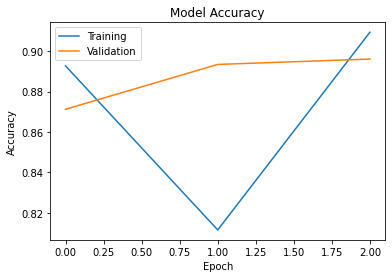

In [51]:
import matplotlib.pyplot as plt
plt.title('Model Accuracy')
plt.plot(hist.history['accuracy'], label='Training')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

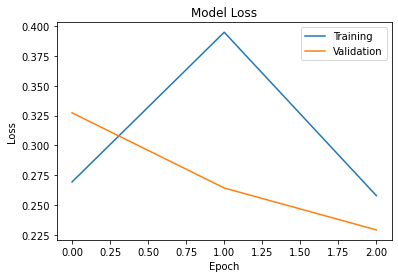

In [52]:
plt.title('Model Loss')
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

Konversi Model ke TF-Lite

In [53]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)